In [1]:
import json
import numpy as np
import pandas as pd
import openml
import pickle
import os
import sys
sys.path.append("..")
from meta_model_training.utils import ndcg_sim, ndcg, custom_sim, load_meta_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

BENCHMARK_RESULTS_DIR = "../meta_dataset_creation/data/benchmark_results/"
META_FEATURES_DIR = "../meta_dataset_creation/data/meta_features/"

dataset_statistics = ["n_instances", "n_features",
                        "dim", "num_on_cat", "n_num_att", "n_cat_att"]

attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_num_att", "std_num_att",
        "card_cat_att", "entropy_cat_att",
        "covariance",
    ]
]

baseline_pairs = {
    "haverage": "manhattan_hamming",
    "fasterpam": "euclidean_hamming",
    "kprototypes": "sqeuclidean_hamming",
}

names = {
    "haverage": "H-AVG",
    "fasterpam": "K-MED",
    # "spectral": "Spectral",
    "kprototypes": "K-PROTO",
}

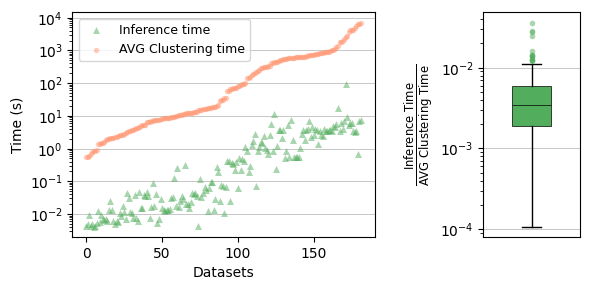

In [2]:
with open(os.path.join(META_FEATURES_DIR, "meta_features_times.json"), "r") as f:
    mf_durations = json.load(f)
    mf_durations = {int(k): v for k, v in mf_durations.items()}

benchmark_durations = {}
for algorithm in ["kprototypes", "fasterpam", "haverage"]:
    with open(os.path.join(BENCHMARK_RESULTS_DIR, f"{algorithm}/times.json"), "r") as f:
        times = json.load(f)
        benchmark_durations[algorithm] = {int(k): v for k, v in times.items()}

x = []
y1 = []
y2 = []
y3 = []
for k, v in benchmark_durations["kprototypes"].items():
    if k in mf_durations:
        x.append(mf_durations[k])
        y1.append(benchmark_durations["kprototypes"][k])
        y2.append(benchmark_durations["fasterpam"][k])
        y3.append(benchmark_durations["haverage"][k])
indices = np.argsort(y1)
x = np.array(x)[indices]
y1 = np.array(y1)[indices]
y2 = np.array(y2)[indices]
y3 = np.array(y3)[indices]
plt.figure(figsize=(6, 3))
plt.subplot(1, 3, (1, 2))
plt.scatter(np.arange(len(x)), x, marker="^", s=25, label="Inference time", c="#52AD5D", linewidths=0, alpha=0.5, zorder=2)
plt.scatter(np.arange(len(y1)), y1/120, s=15, label="AVG Clustering time", c="#FF9671", linewidths=0, alpha=0.5, zorder=2)
plt.yscale("log")
# plt.axhline(y=np.quantile(x/y*120, 0.25), color="gray", linewidth=0.5)
# plt.axhline(y=np.quantile(x/y*120, 0.5), color="gray", linewidth=0.5)
# plt.axhline(y=np.quantile(x/y*120, 0.75), color="gray", linewidth=0.5)
plt.grid(axis="y", linewidth=0.5)
plt.ylabel("Time (s)")
plt.xlabel("Datasets")
plt.legend(fontsize=9)
plt.subplot(1, 3, 3)
boxprops = dict(linewidth=0.5, facecolor="#52AD5D", alpha=1) # "#52AD5D", "#FF9671"
flierprops = dict(marker='o', markerfacecolor="#52AD5D", markeredgecolor='none', markersize=4, alpha=0.5,
                linewidth=0)
medianprops = dict(color='black', linewidth=0.5)
meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
b = plt.boxplot([x/y1*120], widths=0.4, patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
plt.xticks([])
plt.ylabel("$\\frac{\\text{Inference Time}}{\\text{AVG Clustering Time}}$", fontsize=12)
plt.yscale("log")
plt.grid(axis="y", linewidth=0.5)
plt.tight_layout(w_pad=2)
plt.savefig(f"imgs/inference_time_kprototypes.pdf")
plt.show()

In [3]:
# import openml

# openml_df = openml.datasets.list_datasets(output_format="dataframe")
# df = openml_df[openml_df.NumberOfNumericFeatures >= 1]
# df = df[df.NumberOfSymbolicFeatures >= 2]
# df = df[df.NumberOfInstances >= 30]
# df = df[df.NumberOfMissingValues <= 0.1 *
#         df.NumberOfFeatures*df.NumberOfInstances]
# df = df[df.NumberOfClasses >= 2]
# df = df[df.version == 1]
# dict_ = {"NumberOfFeatures":"Features", "NumberOfInstances": "Instances", "NumberOfNumericFeatures":"Num. Features", "NumberOfSymbolicFeatures": "Cat. Features", "NumberOfClasses": "Classes"}
# df= df.rename(columns=dict_)

# dataset_list = [int(filename.split('.')[0])
#                            for filename in os.listdir("meta_dataset_creation/data/benchmark_results/kprototypes/original/scores/")]

# df[df.did.isin(dataset_list)][dict_.values()].describe().astype(int)

In [25]:
train_res_dir = "../meta_model_training/data/training_results/"
train_res = {}
for name in os.listdir(train_res_dir):
    algorithm, eval_metric = name.split('.')[0].split('_')
    print(algorithm, eval_metric)
    if algorithm not in train_res:
        train_res[algorithm] = {}
    filename = os.path.join(train_res_dir, name)
    with open(filename, "rb") as f:
        train_res[algorithm][eval_metric] = pickle.load(f)
        mixed_meta_df, benchmark_results = train_res[algorithm][eval_metric]["meta_dataset"]
        print(mixed_meta_df.shape, benchmark_results.shape)
        Y = benchmark_results.to_numpy()
        if eval_metric in ["acc", "purity"]:
            Yn = np.array([y/max(y) for y in Y])
            # Yn[Yn > 0] **= 4
            Yn[Yn <= 0] = -1
        elif eval_metric == "ari":
            Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
            Yn[Yn <= 0] = -1
        else:
            Yn = np.array([(y+1)/max(y+1) for y in Y])
            Yn[Yn <= 0] = -1
        X = mixed_meta_df.to_numpy()
        sc = StandardScaler().fit(X)
        X = sc.transform(X)
        X2 = X[:, [i for i in range(X.shape[1]) if mixed_meta_df.columns.values[i] in dataset_statistics+attributes_statistics]]
        train_res[algorithm][eval_metric]["Y"] = Y
        train_res[algorithm][eval_metric]["Yn"] = Yn
        train_res[algorithm][eval_metric]["X"] = X
        train_res[algorithm][eval_metric]["X2"] = X2
        # print(train_res[algorithm][eval_metric]["train_results"]["AMF-FS-KNN"])
        selected_feats = train_res[algorithm][eval_metric]["train_results"]["AMF-FS-KNN"]["selected_features"]
        selected_feats2 = train_res[algorithm][eval_metric]["train_results"]["LMF-FS-KNN"]["selected_features"]
        train_res[algorithm][eval_metric]["selected_features"] = mixed_meta_df.columns.to_numpy()[selected_feats]
        train_res[algorithm][eval_metric]["selected_features2"] = np.array([col for col in mixed_meta_df.columns if col in dataset_statistics+attributes_statistics])[selected_feats2]

fasterpam acc
(81, 61) (81, 120)
fasterpam ari
(81, 61) (81, 120)
fasterpam sil
(173, 61) (173, 120)
haverage acc
(94, 61) (94, 120)
haverage ari
(94, 61) (94, 120)
haverage sil
(173, 61) (173, 120)
kprototypes acc
(85, 61) (85, 120)
kprototypes ari
(85, 61) (85, 120)
kprototypes sil
(170, 61) (170, 120)


c:\Users\abdou\Documents\Workspace\Recherche\simrec-for-mdc\venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


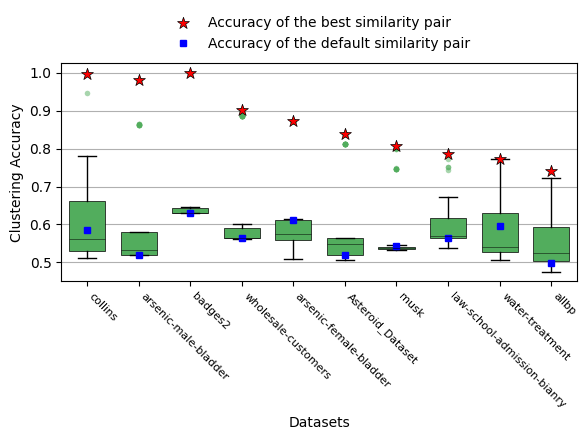

In [ ]:
algorithm = "kprototypes"
eval_metric = "acc"
_ , benchmark_result = train_res[algorithm][eval_metric]["meta_dataset"]
lb_index = benchmark_result.columns.to_list().index(baseline_pairs[algorithm])
# names = []
# for did in benchmark_result.index:
#     filename = f"{algorithm}/scores/"
Y = benchmark_result.to_numpy()
l = np.array([np.mean(max(y) - y[y>-1]) for y in Y])
l = np.argsort(-l)[:10]

plt.figure(figsize=(6, 4.5))
boxprops = dict(linewidth=0.5, facecolor="#52AD5D", alpha=1) # "#52AD5D", "#FF9671"
flierprops = dict(marker='o', markerfacecolor="#52AD5D", markeredgecolor='none', markersize=4, alpha=0.5,
                linewidth=0)
medianprops = dict(color='black', linewidth=0.5, alpha=0.7)
meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
x = np.arange(len(l))
b = plt.boxplot([y[y>-1] for y in Y[l]], positions=x, widths=0.7, patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)

plt.scatter(x, [max(y[y>-1]) for y in Y[l]], marker="*", c="r", s=80, label="Accuracy of the best similarity pair", linewidths=0.5, edgecolor="black", zorder=2)
plt.plot(x, [y[lb_index] for y in Y[l]], "s", color="b", markersize=5, label="Accuracy of the default similarity pair")
plt.xticks(x, [openml.datasets.get_dataset(benchmark_result.index[did]).name for did in l], rotation=-45, horizontalalignment="left", fontsize=8)
# plt.plot(x, [np.median(y[y>-1]) for y in Y[l]], "s", color="r")
plt.xlabel("Datasets")
plt.ylabel("Clustering Accuracy")
plt.grid(axis="y")
plt.legend(fontsize=10, frameon=False, loc= "lower center", bbox_to_anchor= (0.5, 1), ncol=1)
plt.tight_layout()
plt.savefig("imgs/acc_variation_on_some_datasets.pdf", bbox_inches='tight')
plt.show()

In [57]:
results = {}
for algorithm in train_res:
    results[algorithm] = {}
    for eval_metric in train_res[algorithm]:
        print(algorithm, eval_metric)
        results[algorithm][eval_metric] = {}
        Y = train_res[algorithm][eval_metric]["Y"]
        Yn = train_res[algorithm][eval_metric]["Yn"]
        Yn[Yn > 0] **= 4

        ndcg_ranks = [1, 3, 5, 10, 15, 20]
        n_bests = [1, 3, 5, 10]
        ndcg_scores = {
            model_name: {p: np.zeros(X.shape[0]) for p in ndcg_ranks}
            for model_name in train_res[algorithm][eval_metric]["train_results"]
        } #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}
        mrr_scores = {
            model_name: np.zeros(X.shape[0])
            for model_name in train_res[algorithm][eval_metric]["train_results"]
        } #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}

        lb_scores = np.zeros(X.shape[0])
        rb_scores = {k: np.zeros(X.shape[0]) for k in n_bests}
        mb_scores = np.zeros(X.shape[0])
        model_scores = {
            model_name: {k: np.zeros(X.shape[0]) for k in n_bests}
            for model_name in train_res[algorithm][eval_metric]["train_results"]
        } #| {'ensemble': {k: np.zeros(len(test_index)) for k in n_bests}}

        for name, obj in train_res[algorithm][eval_metric]["train_results"].items():
            Y_pred = obj["pred"]
            for p in ndcg_ranks:
                ndcg_scores[name][p] = ndcg(Yn, Y_pred, p=p)
            for k in n_bests:
                model_scores[name][k] = np.array(
                    [max(y[y > -1][np.argsort(-Y_pred[i][y > -1])[:k]]) for i, y in enumerate(Y)])
            mrr_scores[name] = np.array([
                1/(1+list(y[y > -1][np.argsort(-Y_pred[i][y > -1])]).index(max(y))) for i, y in enumerate(Y)
            ])
        for k in n_bests:
            rb_scores[k] = np.array(
                [max(np.random.choice(y[y > -1], k)) for y in Y])
    
        benchmark_results = train_res[algorithm][eval_metric]["meta_dataset"][1]
        similarity_pairs = benchmark_results.columns.values
        sim_pairs_index = dict(zip(similarity_pairs, range(len(similarity_pairs))))
        lb_scores = Y[:, sim_pairs_index[baseline_pairs[algorithm]]]
        mb_scores = np.max(Y, axis=1)

        results[algorithm][eval_metric]["scores"] = model_scores
        results[algorithm][eval_metric]["scores"]["LB"] = {1: lb_scores}
        results[algorithm][eval_metric]["scores"]["RB"] = rb_scores
        results[algorithm][eval_metric]["scores"]["Oracle"] = {1: mb_scores}
        results[algorithm][eval_metric]["ndcg"] = ndcg_scores
        results[algorithm][eval_metric]["mrr"] = mrr_scores

fasterpam acc
fasterpam ari
fasterpam sil
haverage acc
haverage ari
haverage sil
kprototypes acc
kprototypes ari
kprototypes sil


In [13]:
sota_results = {
    "786": {
        "name": "cleveland", #heart-desease
        "acc": {
            # "CB-DCGANs": 0.885,  # Clustering of mixed datasets using deep learning algorithm
            # "DP-MD-FN": 0.8148,  # An entropy-based density peaks clustering algorithm for mixed type data employing fuzzy neighborhood
            "OCIL": 0.7411, # An entropy-based density peaks clustering algorithm for mixed type data employing fuzzy neighborhood
            "SBAC": 0.7525,  # A novel density peaks clustering algorithm for mixed data
            # "DPC-MD": 0.8218, # A novel density peaks clustering algorithm for mixed data
            "OCIL2": 0.8313, # Categorical-and-numerical-attribute data clustering based on a unified similarity metric
            "ADC": 0,
        }
    },
    "29": {
        "name": "credit-aproval",
        "acc": {
            # "CB-DCGANs": 0,
            # "DP-MD-FN": 0.8668, # An entropy-based density peaks clustering algorithm for mixed type data employing fuzzy neighborhood
            "OCIL": 0.6634, # An entropy-based density peaks clustering algorithm for mixed type data employing fuzzy neighborhood
            "SBAC": 0.7525, # A novel density peaks clustering algorithm for mixed data
            # "DPC-MD": 0.8407, # A novel density peaks clustering algorithm for mixed data
            "OCIL2": 0.7563, # Categorical-and-numerical-attribute data clustering based on a unified similarity metric
            "ADC": 0, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
        }
    },
    "40981": {
        "name": "australian-credit-aproval",
        "acc": {
            # "CB-DCGANs": 0,
            # "DP-MD-FN": 0.8551, # An entropy-based density peaks clustering algorithm for mixed type data employing fuzzy neighborhood
            "OCIL": 0.6668, # An entropy-based density peaks clustering algorithm for mixed type data employing fuzzy neighborhood
            "SBAC": 0.6000, # A novel density peaks clustering algorithm for mixed data
            # "DPC-MD": 0.8652, # A novel density peaks clustering algorithm for mixed data
            "OCIL2": 0, # Categorical-and-numerical-attribute data clustering based on a unified similarity metric
            "ADC": 0.7942, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
        }
    },
    # "10": {
    #     "name": "lymphography",
    #     "acc": {
    #         # "CB-DCGANs": 0,
    #         "DP-MD-FN": 0,
    #         "OCIL": 0,
    #         "SBAC": 0.5676, # A novel density peaks clustering algorithm for mixed data
    #         "DPC-MD": 0.8218, # A novel density peaks clustering algorithm for mixed data
    #         "OCIL2": 0.6154, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
    #         "ADC": 0.6928, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
    #     }
    # },
    # "31": {
    #     "name": "german credit",
    #     "acc": {
    #         "CB-DCGANs": 0,
    #         "DP-MD-FN": 0,
    #         "OCIL": 0,
    #         "SBAC": 0,
    #         "DPC-MD": 0,
    #         "OCIL2": 0.6943, # Categorical-and-numerical-attribute data clustering based on a unified similarity metric
    #         "ADC": 0.6134, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
    #     }
    # },
    "35": {
        "name": "dermatology",
        "acc": {
            # "CB-DCGANs": 0,
            # "DP-MD-FN": 0,
            "OCIL": 0,
            "SBAC": 0,
            # "DPC-MD": 0,
            "OCIL2": 0.6974, # Categorical-and-numerical-attribute data clustering based on a unified similarity metric
            "ADC": 0.834, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
        }
    },
    "45557": {
        "name": "mammographic",
        "acc": {
            # "CB-DCGANs": 0,
            # "DP-MD-FN": 0,
            "OCIL": 0,
            "SBAC": 0,
            # "DPC-MD": 0,
            "OCIL2": 0, # Categorical-and-numerical-attribute data clustering based on a unified similarity metric
            "ADC": 0.8313, # Graph-Based Dissimilarity Measurement for Cluster Analysis of Any-Type-Attributed Data
        }
    }
}

In [14]:
algorithm, eval_metric = "fasterpam", "acc"
benchmark_results = train_res[algorithm][eval_metric]["meta_dataset"][1]
dataId2idx = dict(zip(benchmark_results.index.values, np.arange(benchmark_results.shape[0])))
obj = {}
for data_id, res in sota_results.items():
    name = res["name"]
    obj[name] = {}
    for method, score in res["acc"].items():
        if score > 0:
            obj[name][method] = score
    obj[name]["SimRec"] = results[algorithm][eval_metric]["scores"]["AMF-FS-KNN"][1][dataId2idx[data_id]]
    obj[name]["Best"] = max(benchmark_results.loc[data_id])
pd.DataFrame.from_dict(obj, orient="index")

,OCIL,SBAC,OCIL2,SimRec,Best,ADC
cleveland,0.7411,0.7525,0.8313,0.818182,0.858586,NaN
credit-aproval,0.6634,0.7525,0.7563,0.800919,0.840735,NaN
australian-credit-aproval,0.6668,0.6000,NaN,0.849275,0.853623,0.7942
dermatology,NaN,NaN,0.6974,0.946927,0.946927,0.8340
mammographic,NaN,NaN,NaN,0.789410,0.797834,0.8313


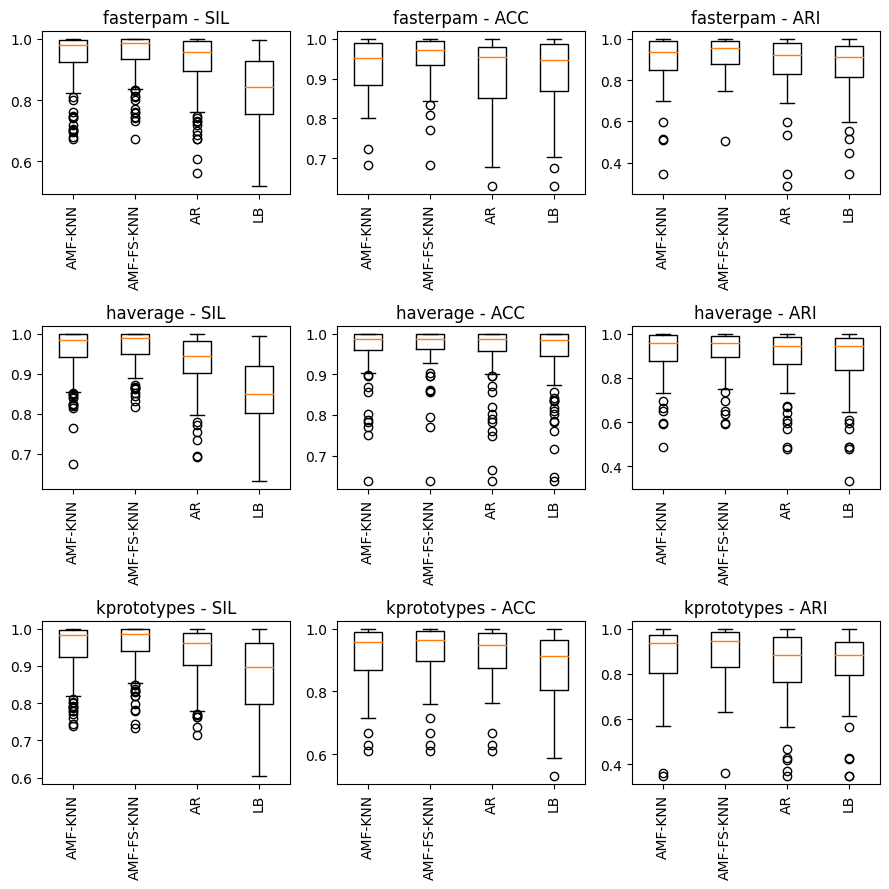

In [15]:
rows, cols = 3, 3
model_names = ["AMF-KNN", "AMF-FS-KNN", "AR", "LB"]
plt.figure(figsize=(cols*3, rows*3))
i = 1
for algorithm in results:
    for eval_metric in ["sil", "acc", "ari"]:
        y = {}
        best_scores = results[algorithm][eval_metric]["scores"]["Oracle"][1]
        lb_scores = results[algorithm][eval_metric]["scores"]["LB"][1]
        for name in model_names:
            l = results[algorithm][eval_metric]["scores"][name][1]
            if eval_metric in ["sil"]:
                y[name] = (l+1)/(best_scores+1)
            elif eval_metric in ["acc"]:
                y[name] = (l)/(best_scores)
            elif eval_metric in ["ari"]:
                y[name] = (l+0.5)/(best_scores+0.5)
            # y[name] = (l-lb_scores)
        plt.subplot(rows, cols, i)
        # print(list(y.values())[0])
        plt.boxplot(y.values(), labels=y.keys())
        plt.title(f"{algorithm} - {eval_metric.upper()}")
        plt.xticks(rotation="vertical")
        i += 1
plt.tight_layout()
plt.show()

In [54]:
model_names = ["LB", "RB", "AR", "AMF-FS-KNN", "Oracle"]
obj = {name: {} for name in model_names}
for algorithm in ["kprototypes", "fasterpam", "haverage"]:
    for eval_metric in ["sil", "ari", "acc"]:    
        Y = train_res[algorithm][eval_metric]["Y"]
        lb_scores = results[algorithm][eval_metric]["scores"]["LB"][1]
        for name in model_names:
            l = results[algorithm][eval_metric]["scores"][name][1]
            # if eval_metric in ["sil"]:
            #     l = (l+1)/(best_scores+1)
            # elif eval_metric in ["acc"]:
            #     l = (l)/(best_scores)
            # elif eval_metric in ["ari"]:
            #     l = (l+0.5)/(best_scores+0.5)
            obj[name][f"{algorithm[0]}-{eval_metric}"] = \
                f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}" + \
                    (f" ↑{int((np.mean(l)/np.mean(lb_scores)-1)*100)}%" if name=="AMF-FS-KNN" else "")
        
        # obj["Oracle"][f"{algorithm[0]}-{eval_metric}"] = \
        #         f"{np.format_float_positional(np.mean(best_scores), 3)}±{np.format_float_positional(np.std(best_scores), 2)}"

print(pd.DataFrame.from_dict(obj, orient="columns"))
print()

               LB          RB          AR       AMF-FS-KNN      Oracle
k-sil  0.473±0.23  0.445±0.23   0.570±0.2  0.614±0.21 ↑29%  0.685±0.20
k-ari  0.245±0.24  0.216±0.23  0.235±0.23  0.301±0.26 ↑22%  0.389±0.25
k-acc  0.721±0.12  0.727±0.11  0.755±0.10   0.766±0.10 ↑6%  0.824±0.08
f-sil  0.417±0.23  0.432±0.22  0.574±0.23  0.621±0.22 ↑48%    0.7±0.21
f-ari   0.25±0.24  0.234±0.23  0.257±0.24  0.311±0.27 ↑24%  0.374±0.27
f-acc  0.751±0.10  0.744±0.10  0.749±0.11   0.782±0.10 ↑4%   0.82±0.08
h-sil   0.519±0.2  0.566±0.22  0.654±0.19  0.727±0.18 ↑40%  0.781±0.18
h-ari  0.217±0.24  0.192±0.23  0.243±0.26  0.263±0.26 ↑21%  0.326±0.26
h-acc   0.793±0.1  0.777±0.12  0.801±0.10   0.809±0.09 ↑2%  0.836±0.08



In [13]:
model_names = ["AR", "AMF-FS-KNN"]
obj = {name: {} for name in model_names}
for algorithm in ["kprototypes", "fasterpam", "haverage"]:
    for eval_metric in ["sil", "ari", "acc"]:    
        Y = train_res[algorithm][eval_metric]["Y"]
        for name in model_names:
            l = results[algorithm][eval_metric]["mrr"][name]
            obj[name][f"{algorithm[0]}-{eval_metric}"] = \
                f"{np.format_float_positional(np.mean(l), 3)}"
            # plt.hist(1/l, bins=30, alpha=0.5)
        plt.show()
print(pd.DataFrame.from_dict(obj, orient="columns"))
print()

          AR AMF-FS-KNN
k-sil  0.207      0.326
k-ari  0.117      0.221
k-acc  0.208      0.249
f-sil  0.258      0.328
f-ari  0.122      0.231
f-acc  0.164      0.259
h-sil  0.120      0.356
h-ari   0.22       0.24
h-acc  0.216      0.252



In [58]:
model_names = ["AR", "AMF-FS-KNN"]
obj = {}
for algorithm in ["kprototypes", "fasterpam", "haverage"]:
    for eval_metric in ["sil", "ari", "acc"]:    
        Y = train_res[algorithm][eval_metric]["Y"]
        obj[f"{algorithm[0]}-{eval_metric}"] = {}
        for name in model_names:
            l = results[algorithm][eval_metric]["scores"][name][10]
            obj[f"{algorithm[0]}-{eval_metric}"][f"{name}-top10"] = \
                f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}"
                
        for name in model_names:                
            l = results[algorithm][eval_metric]["ndcg"][name][10]
            obj[f"{algorithm[0]}-{eval_metric}"][f"{name}-ndcg"] = \
                f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}"
print(pd.DataFrame.from_dict(obj, orient="index"))
print() 

         AR-top10 AMF-FS-KNN-top10     AR-ndcg AMF-FS-KNN-ndcg
k-sil  0.626±0.20       0.643±0.20  0.775±0.17      0.823±0.16
k-ari  0.275±0.24       0.332±0.26  0.622±0.27      0.696±0.24
k-acc   0.776±0.1        0.782±0.1  0.748±0.21      0.767±0.21
f-sil  0.641±0.22       0.668±0.21  0.768±0.17      0.823±0.16
f-ari  0.299±0.26       0.332±0.27  0.684±0.23      0.730±0.21
f-acc   0.78±0.09        0.797±0.1  0.763±0.21      0.816±0.16
h-sil  0.724±0.19       0.746±0.18  0.783±0.15      0.869±0.13
h-ari  0.295±0.27       0.293±0.27  0.734±0.21      0.752±0.21
h-acc  0.823±0.09       0.823±0.08  0.864±0.17      0.876±0.15



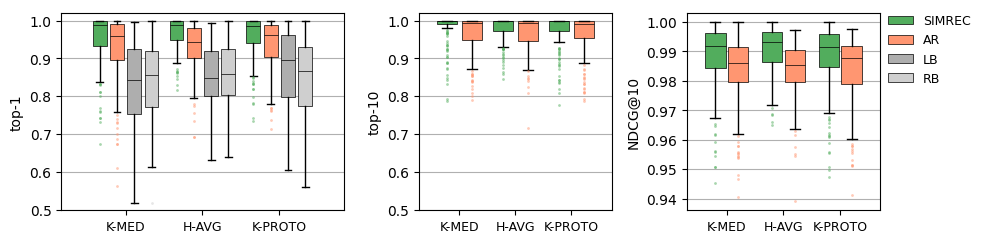

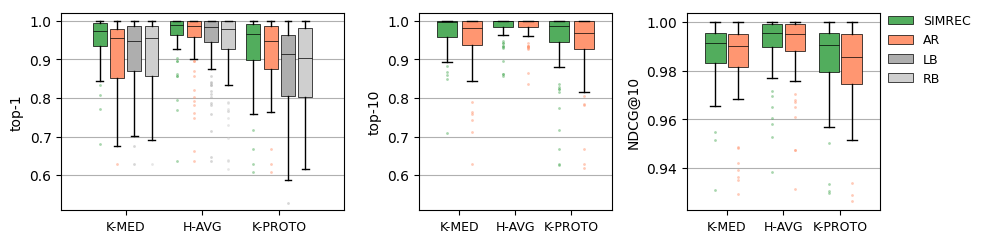

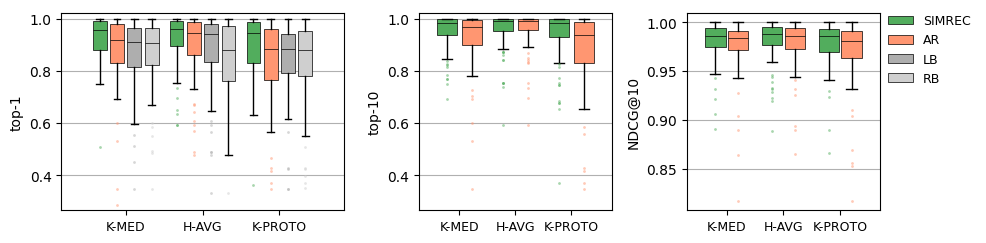

In [8]:
def show_scores(results, savedir=None):
    colors = {
        "AMF-FS-KNN": "#52AD5D",
        # "AMF-AE-KNN": "#FF9671",
        "AR": "#FF9671",
        # "AR": "#868686",
        "LB": "#AEAEAE",
        "RB": "#CFCFCF",
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "SIMREC"
    # labels["AMF-AE-KNN"] = "AE-KNN"

    model_names = ["AMF-FS-KNN", "AR"] #, "MKNN", "MDTree", "PR-LR", "PR-KNN", "PR-DTree"
    for eval_metric in ["sil", "acc", "ari"]:
        fig = plt.figure(figsize=(9, 2.5))
        
        plt.subplot(1, 10, (1, 4))
        k = 1
        baselines = ["LB", "RB"]
        y = {}
        min_ = 1
        for algorithm in results:
            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[model_name].append(v)

            for name in baselines:
                if name not in y:
                    y[name] = []
                l = res[name][1]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():
            min_ = min(min_, min(min(val) for val in values))          
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.8*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        plt.ylabel(f"top-{k}")
        plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        
        plt.subplot(1, 10, (5, 7))
        k = 10
        y = {}
        for algorithm in results:
            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.8*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            i+=1
        plt.ylabel(f"top-{k}")
        plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        
        plt.subplot(1, 10, (8, 10))
        k = 10
        y = {}
        for algorithm in results:
            res = results[algorithm][eval_metric]["ndcg"]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                v = res[model_name][k]
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.8/n_bar
        x = np.arange(len(results))
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.9*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            i+=1
        plt.ylabel(f"NDCG@{k}")
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        
        # if eval_metric=="sil":
        #     plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines))
        plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.98), frameon=False)

        plt.tight_layout()
        # if savedir is not None:
        #     plt.savefig(os.path.join(savedir, f"results_{eval_metric}.pdf"), bbox_inches='tight')
        plt.show()

show_scores(results, savedir="imgs/")

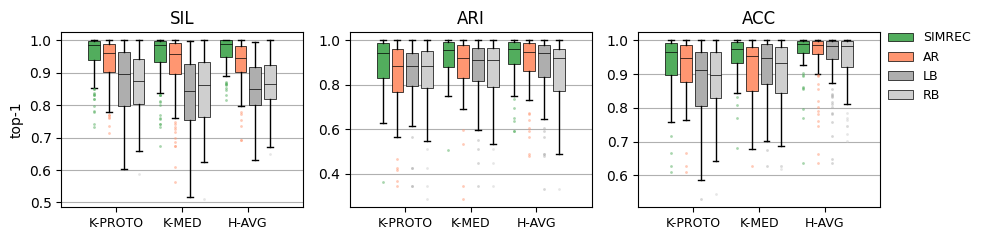

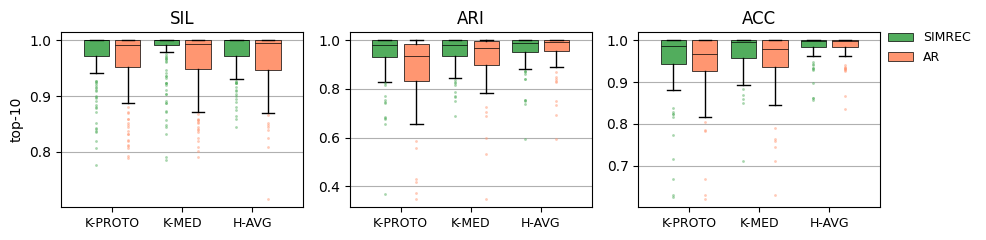

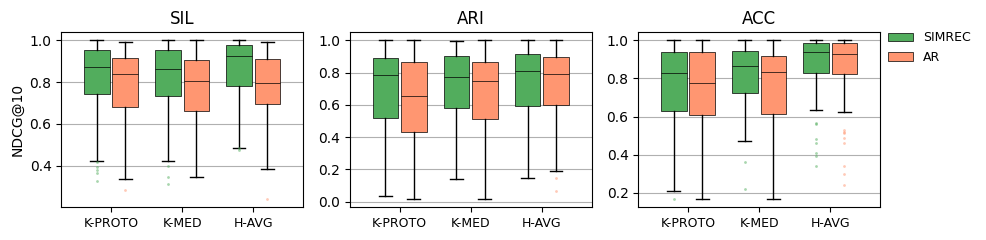

In [59]:
def show_scores(results, savedir=None):
    colors = {
        "AMF-FS-KNN": "#52AD5D", 
        # "AMF-AE-KNN": "#FF9671",
        "AR": "#FF9671",
        # "AR": "#868686",
        "LB": "#AEAEAE",
        "RB": "#CFCFCF",
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "SIMREC"
    # labels["AMF-AE-KNN"] = "AE-KNN"

    model_names = ["AMF-FS-KNN", "AR"] #, "MKNN", "MDTree", "PR-LR", "PR-KNN", "PR-DTree"

    fig = plt.figure(figsize=(9, 2.5))
    k = 1
    baselines = ["LB", "RB"]
    for j, eval_metric in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in ["kprototypes", "fasterpam", "haverage"]:
            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[model_name].append(v)

            for name in baselines:
                if name not in y:
                    y[name] = []
                l = res[name][1]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():
            # min_ = min(min_, min(min(val) for val in values))          
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.8*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        if j==0: plt.ylabel(f"top-{k}")
        # plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in ["kprototypes", "fasterpam", "haverage"]], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title(eval_metric.upper())
    plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"results_top{k}.pdf"), bbox_inches='tight')
    plt.show()
        
    fig = plt.figure(figsize=(9, 2.5))
    k = 10
    for j, eval_metric in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in ["kprototypes", "fasterpam", "haverage"]:
            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.8*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        if j==0: plt.ylabel(f"top-{k}")
        # plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in ["kprototypes", "fasterpam", "haverage"]], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title(eval_metric.upper())
    plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"results_top{k}.pdf"), bbox_inches='tight')
    plt.show()
        
    fig = plt.figure(figsize=(9, 2.5))
    for j, eval_metric in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in ["kprototypes", "fasterpam", "haverage"]:
            res = results[algorithm][eval_metric]["ndcg"]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                v = res[model_name][k]
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.8/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.9*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        if j==0: plt.ylabel(f"NDCG@{k}")
        plt.xticks(x, [names[algo] for algo in ["kprototypes", "fasterpam", "haverage"]], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title(eval_metric.upper())
        
        # if eval_metric=="sil":
        #     plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines))
    plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"results_ndcg{k}.pdf"), bbox_inches='tight')
    plt.show()

show_scores(results) #, savedir="imgs/"

In [61]:
from scipy.stats import wilcoxon, ttest_rel

model_name = "AMF-FS-KNN"
baselines = ["AR", "LB", "RB"]
k = 1
for name in baselines:
    y_1 = {}
    for eval_metric in ["sil", "ari", "acc"]:
        y_1[eval_metric.upper()] = {}
        for algorithm in ["kprototypes", "fasterpam", "haverage"]:
            res = results[algorithm][eval_metric]["scores"]
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_1[eval_metric.upper()][f"{algorithm[0]}-{name}"] = f"{p:.3f}"
    print(pd.DataFrame.from_dict(y_1, orient='index'))

baselines = ["AR"]
y_10 = {}
k = 10
for eval_metric in ["sil", "ari", "acc"]:
    y_10[eval_metric.upper()] = {}
    for algorithm in ["kprototypes", "fasterpam", "haverage"]:
        res = results[algorithm][eval_metric]["scores"]
        for name in baselines:
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_10[eval_metric.upper()][f"{algorithm[0]}-{name}"] = f"{p:.3f}"
print(pd.DataFrame.from_dict(y_10, orient='index'))

y_ndcg = {}
k = 10
for eval_metric in ["sil", "ari", "acc"]:
    y_ndcg[eval_metric.upper()] = {}
    for algorithm in ["kprototypes", "fasterpam", "haverage"]:
        res = results[algorithm][eval_metric]["ndcg"]
        for name in baselines:
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_ndcg[eval_metric.upper()][f"{algorithm[0]}-{name}"] = f"{p:.3f}"
print(pd.DataFrame.from_dict(y_ndcg, orient='index'))

      k-AR   f-AR   h-AR
SIL  0.000  0.000  0.000
ARI  0.000  0.002  0.004
ACC  0.003  0.000  0.037
      k-LB   f-LB   h-LB
SIL  0.000  0.000  0.000
ARI  0.000  0.000  0.001
ACC  0.000  0.001  0.011
      k-RB   f-RB   h-RB
SIL  0.000  0.000  0.000
ARI  0.000  0.000  0.000
ACC  0.000  0.000  0.004
      k-AR   f-AR   h-AR
SIL  0.000  0.000  0.000
ARI  0.000  0.002  0.762
ACC  0.034  0.004  0.583
      k-AR   f-AR   h-AR
SIL  0.000  0.000  0.000
ARI  0.007  0.002  0.228
ACC  0.086  0.023  0.184


In [66]:
from scipy.stats import wilcoxon, ttest_rel

model_name = "AMF-FS-KNN"
baselines = ["AR", "LB", "RB"]
k = 1
y_1 = {}
for algorithm in ["kprototypes", "fasterpam", "haverage"]:
    for eval_metric in ["sil", "ari", "acc"]:
        y_1[names[algorithm][:3]+" "+eval_metric.upper()] = {}
        for name in baselines:
            res = results[algorithm][eval_metric]["scores"]
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_1[names[algorithm][:3]+" "+eval_metric.upper()][name] = f"{p:.3f}"
print(pd.DataFrame.from_dict(y_1, orient='columns'))
print()

baselines = ["AR"]
y = {}
k = 10
for algorithm in ["kprototypes", "fasterpam", "haverage"]:
    for eval_metric in ["sil", "ari", "acc"]:
        y[names[algorithm][:3]+" "+eval_metric.upper()] = {}
        res = results[algorithm][eval_metric]["scores"]
        for name in baselines:
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y[names[algorithm][:3]+" "+eval_metric.upper()]["top10"] = f"{p:.3f}"

        res = results[algorithm][eval_metric]["ndcg"]
        for name in baselines:
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y[names[algorithm][:3]+" "+eval_metric.upper()]["ndcg10"] = f"{p:.3f}"
print(pd.DataFrame.from_dict(y, orient='columns'))

   K-P SIL K-P ARI K-P ACC K-M SIL K-M ARI K-M ACC H-A SIL H-A ARI H-A ACC
AR   0.000   0.000   0.003   0.000   0.002   0.000   0.000   0.004   0.037
LB   0.000   0.000   0.000   0.000   0.000   0.001   0.000   0.001   0.011
RB   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.004

       K-P SIL K-P ARI K-P ACC K-M SIL K-M ARI K-M ACC H-A SIL H-A ARI H-A ACC
top10    0.000   0.000   0.034   0.000   0.002   0.004   0.000   0.762   0.583
ndcg10   0.000   0.007   0.086   0.000   0.002   0.023   0.000   0.228   0.184


[57, 56, 57]
[58, 57, 58]
[58, 57, 58]


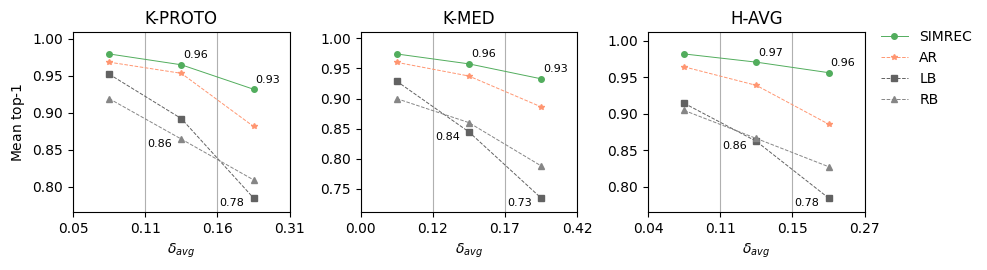

[29, 28, 28]
[27, 27, 27]
[32, 31, 31]


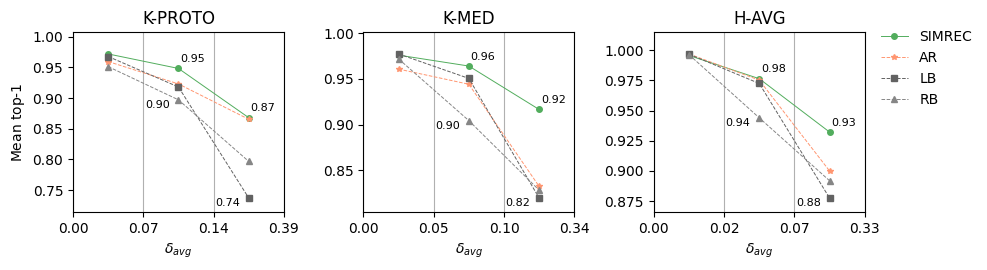

[29, 28, 28]
[27, 27, 27]
[32, 31, 31]


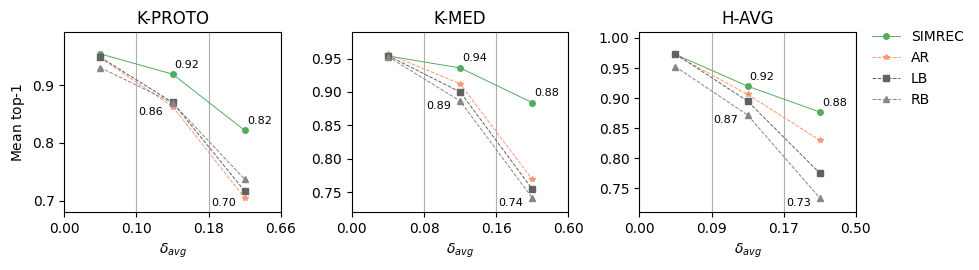

In [69]:
def show_results_delta(results, eval_metric="sil", savedir=None, list_algo=None):
    model_names = ["AMF-FS-KNN", "AR"]
    colors = {
        "AMF-FS-KNN": "#52AD5D",
        "AR": "#FF9671",
        "LB": "#626262",
        "RB": "#868686",
        # "AR": "#AFAFAF"
    }

    linestyle = {
        "AMF-FS-KNN": "-o",
        "AR": "--*",
        "LB": "--s",
        "RB": "--^"
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "SIMREC"

    for eval_metric in ["sil", "acc", "ari"]:
        plt.figure(figsize=(3*3, 2.8))
        j = 1
        for algorithm in ["kprototypes", "fasterpam", "haverage"]:
            plt.subplot(1, 3, j)
            Y = train_res[algorithm][eval_metric]["Y"]
            if eval_metric in ["acc", "purity"]:
                Yn = np.array([y/max(y) for y in Y])
                # Yn[Yn > 0] **= 4
                Yn[Yn <= 0] = -1
            elif eval_metric == "ari":
                Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
                Yn[Yn <= 0] = -1
            else:
                Yn = np.array([(y+1)/max(y+1) for y in Y])
                Yn[Yn <= 0] = -1

            res = results[algorithm][eval_metric]["scores"]
            
            best_scores = res["Oracle"][1]
            lb_scores = res["LB"][1]
            l = [np.mean(1 - y[y>-1]) for i, y in enumerate(Yn)]
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
            
            x[0] -= 1e-4
            diff = 0.025
            list_indices = [
                [xr < np.mean(1 - y[y>-1]) <= x[r+1] for i, y in enumerate(Yn)]
                for r, xr in enumerate(x[:-1])
            ] #

            k=1
            baselines = ["LB", "RB"]
            # baselines = []
            y = {}
            yerr = {}
            print([sum(indices) for indices in list_indices])
            for model_name in model_names:
                y[model_name] = []
                yerr[model_name] = []
                scores = res[model_name][k]
                for i, indices in enumerate(list_indices):
                    if eval_metric in ["sil"]:
                        ln = ((scores+1)/(best_scores+1))[indices]
                    elif eval_metric in ["ari"]:
                        ln = ((scores+0.5)/(best_scores+0.5))[indices]
                    else:
                        ln = (scores/best_scores)[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[model_name].append(v)
                    yerr[model_name].append(std)

            for name in baselines:
                y[name] = []
                yerr[name] = []
                scores = res[name][1]
                for i, indices in enumerate(list_indices):
                    if eval_metric in ["sil"]:
                        ln = ((scores+1)/(best_scores+1))[indices]
                    elif eval_metric in ["ari"]:
                        ln = ((scores+0.5)/(best_scores+0.5))[indices]
                    else:
                        ln = (scores/best_scores)[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[name].append(v)
                    yerr[name].append(std)

            n_bar = len(y)
            w = 0.8/n_bar
            z = np.arange(len(x))
            i = 0
            max_ = np.zeros(len(list_indices))
            min_ = np.ones(len(list_indices))*100
            for model_name, values in y.items():
                max_ = np.maximum(max_, values)
                min_ = np.minimum(min_, values)
                plt.plot(z[:-1]+0.5, values, linestyle[model_name], linewidth=0.7, c=colors[model_name], label=labels[model_name] if j==1 else None, markersize=4, zorder=10)
                i += 1

            # delta_x = max(x) - min(x)
            delta_y = max(max_) - min(min_)
            for ind, val in enumerate(list_indices):
                if ind >= 1:
                    plt.annotate(f"{max_[ind]:.02f}", (z[ind]+0.7, max_[ind]+delta_y*0.1), fontsize=8, ha="center", va="top")
                    plt.annotate(f"{min_[ind]:.02f}", (z[ind]+0.2, min_[ind]), fontsize=8, ha="center", va="top")

            plt.xlim((z[0], z[-1]))
            plt.ylim((min(min_) - delta_y*0.1, max(max_) + delta_y*0.15))
            if j == 1: plt.ylabel(f"Mean top-${k}$")
            plt.xticks(z, [f"{max(0, val):.2f}" for val in x])
            plt.grid(axis="x")
            plt.xlabel("$\delta_{avg}$")
            plt.title(names[algorithm])

            j += 1

        # if eval_metric=="sil":
        #     plt.figlegend(loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines), fontsize=10)
        plt.figlegend(fontsize=10, loc= "upper left", bbox_to_anchor= (0.97, 0.92), frameon=False)

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"results_delta_{eval_metric}.pdf"), bbox_inches='tight')
        plt.show()

show_results_delta(results, savedir="imgs") #

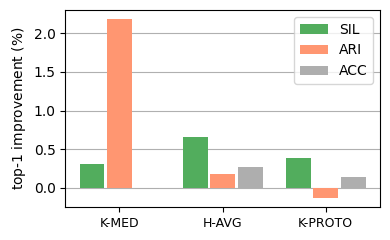

In [18]:
def show_impact_fs(results, savedir=None):
    colors = {
        "sil": "#52AD5D",
        # "AMF-AE-KNN": "#FF9671",
        "ari": "#FF9671",
        # "AR": "#868686",
        "acc": "#AEAEAE",
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "With FS"
    labels["AMF-KNN"] = "Without FS"

    model_names = ["AMF-FS-KNN", "LMF-FS-KNN"] #, "MKNN", "MDTree", "PR-LR", "PR-KNN", "PR-DTree"

    fig = plt.figure(figsize=(4, 2.5))
    k = 1
    baselines = []
    y = {}
    for j, eval_metric in enumerate(["sil", "ari", "acc"]):
        y[eval_metric] = []
        for algorithm in ["kprototypes", "fasterpam", "haverage"]:
            Y = train_res[algorithm][eval_metric]["Y"]
            if eval_metric in ["acc", "purity"]:
                Yn = np.array([y/max(y) for y in Y])
                # Yn[Yn > 0] **= 4
                Yn[Yn <= 0] = -1
            elif eval_metric == "ari":
                Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
                Yn[Yn <= 0] = -1
            else:
                Yn = np.array([(y+1)/max(y+1) for y in Y])
                Yn[Yn <= 0] = -1

            l = [np.mean(1 - y[y>-1]) for i, y in enumerate(Yn)]
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
            list_indices = [
                [xr < np.mean(1 - y[y>-1]) <= x[r+1] for i, y in enumerate(Yn)]
                for r, xr in enumerate(x[:-1])
            ] #

            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            l1 = res[model_names[0]][k]
            l2 = res[model_names[1]][k]
            if eval_metric in ["sil"]:
                l1 = (l1+1)/(best_scores+1)
                l2 = (l2+1)/(best_scores+1)
            elif eval_metric in ["acc"]:
                l1 = (l1)/(best_scores)
                l2 = (l2)/(best_scores)
            elif eval_metric in ["ari"]:
                l1 = (l1+0.5)/(best_scores+0.5)
                l2 = (l2+0.5)/(best_scores+0.5)
            v = (l1 - l2)/l2
            y[eval_metric].append(np.mean(v)*100)

    n_bar = len(y)
    w = 0.8/n_bar
    x = np.arange(len(results))
    boxes = []
    i = 0
    for eval_metric, values in y.items():
        # boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
        # flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
        #                 linewidth=0)
        # medianprops = dict(color='black', linewidth=0.5)
        # meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
        plt.bar(x+(i*w-(n_bar-1)*w/2), values, width=w*0.9, label=eval_metric.upper(), color=colors[eval_metric], zorder=2)
        i+=1
    plt.ylabel(f"top-${k}$ improvement (%)")
    # plt.ylim((0.85, 1.0))
    plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
    plt.grid(axis="y")

    plt.legend()
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"impact_fs_top{k}.pdf"), bbox_inches='tight')
    plt.show()

show_impact_fs(results) #, savedir="imgs/"

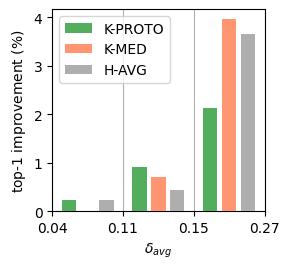

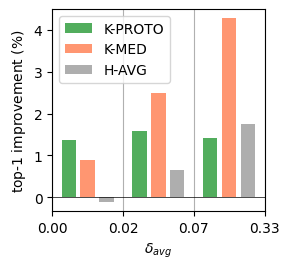

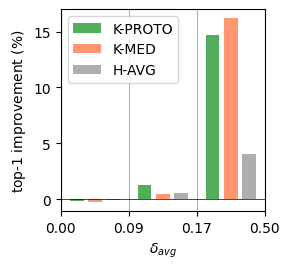

In [17]:
def show_impact_fs_delta(results, eval_metric="sil", savedir=None, list_algo=None):
    model_names = ["AMF-FS-KNN", "AMF-KNN"]
    color = "#52AD5D"
    colors = {
        "kprototypes": "#52AD5D",
        # "AMF-AE-KNN": "#FF9671",
        "fasterpam": "#FF9671",
        # "AR": "#868686",
        "haverage": "#AEAEAE",
    }

    linestyle = {
        "kprototypes": "-o",
        "fasterpam": "--*",
        "haverage": "--s",
    }
    k = 1
    for eval_metric in ["sil", "acc", "ari"]:
        y = {}
        yerr = {}
        plt.figure(figsize=(3, 2.8))
        for algorithm in ["kprototypes", "fasterpam", "haverage"]:
            y[algorithm] = []
            yerr[algorithm] = []
            Y = train_res[algorithm][eval_metric]["Y"]
            if eval_metric in ["acc", "purity"]:
                Yn = np.array([y/max(y) for y in Y])
                # Yn[Yn > 0] **= 4
                Yn[Yn <= 0] = -1
            elif eval_metric == "ari":
                Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
                Yn[Yn <= 0] = -1
            else:
                Yn = np.array([(y+1)/max(y+1) for y in Y])
                Yn[Yn <= 0] = -1

            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            l = [np.mean(1 - y[y>-1]) for i, y in enumerate(Yn)]
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
            
            x[0] -= 1e-4
            list_indices = [
                [xr < np.mean(1 - y[y>-1]) <= x[r+1] for i, y in enumerate(Yn)]
                for r, xr in enumerate(x[:-1])
            ] #
            l1 = res[model_names[0]][k]
            l2 = res[model_names[1]][k]
            if eval_metric in ["sil"]:
                l1 = (l1+1)/(best_scores+1)
                l2 = (l2+1)/(best_scores+1)
            elif eval_metric in ["acc"]:
                l1 = (l1)/(best_scores)
                l2 = (l2)/(best_scores)
            elif eval_metric in ["ari"]:
                l1 = (l1+0.5)/(best_scores+0.5)
                l2 = (l2+0.5)/(best_scores+0.5)
            v = (l1 - l2)/l2
            for indices in list_indices:
                y[algorithm].append(np.mean(v[indices])*100)
                yerr[algorithm].append(np.std(v[indices])*100)

        z = np.arange(len(x))
        n_bar = len(y)
        w = 0.8/n_bar
        boxes = []
        i = 0
        for algorithm, values in y.items():
            # boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            # flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
            #                 linewidth=0)
            # medianprops = dict(color='black', linewidth=0.5)
            # meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            plt.bar(z[:-1]+(i*w-(n_bar-1)*w/2)+0.5, values, width=w*0.75, label=names[algorithm], color=colors[algorithm], zorder=5)
            i+=1

        plt.xlim((z[0], z[-1]))
        plt.ylabel(f"top-${k}$ improvement (%)")
        plt.xticks(z, [f"{max(0, val):.2f}" for val in x])
        plt.grid(axis="x")
        plt.xlabel("$\delta_{avg}$")
        plt.axhline(linewidth=0.5, color="black", zorder=10)

        plt.legend(fontsize=10)

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"impact_fs_delta_{eval_metric}.pdf"), bbox_inches='tight')
        plt.show()

show_impact_fs_delta(results) #, savedir="imgs"

In [19]:
dataset_statistics = ["n_instances", "n_features",
                      "dim", "num_on_cat", "n_num_att", "n_cat_att"]
attributes_statistics_num = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_num_att", "std_num_att",
        "covariance",
    ]
]
attributes_statistics_cat = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "card_cat_att", "entropy_cat_att",
    ]
]
proposed_attributes_statistics_num = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_squared_num_att", "std_squared_num_att",
        "means_internal_product_num_att", "std_internal_product_num_att",
    ]
]
proposed_attributes_statistics_cat = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "mutual_info_cat_att",
        "std_freq_cat_att"
    ]
]
proposed_attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_squared_num_att", "std_squared_num_att",
        "means_internal_product_num_att", "std_internal_product_num_att",
        "mutual_info_cat_att",
        "std_freq_cat_att"
    ]
]

features = {
    "d": dataset_statistics,
    "n_at": attributes_statistics_num,
    "c_at": attributes_statistics_cat,
    "p_n_at": proposed_attributes_statistics_num,
    "p_c_at": proposed_attributes_statistics_cat,
}

In [20]:
algorithm = "haverage"
for eval_metric in ["sil", "ari", "acc"]:
    obj = {}
    for algorithm in train_res:
        obj[names[algorithm]] = {}
        selected_features = train_res[algorithm][eval_metric]["selected_features"]
        for k, list_features in features.items():
            l = [f for f in list_features if f in selected_features]
            obj[names[algorithm]][k] = len(l)
            # obj[algorithm][k] = f"{len(l)/len(selected_features)*100:.1f}"
            # obj[k]["feats"] = [f for f in list_features if f in selected_features]
        obj[names[algorithm]]['total'] = len(selected_features)
    print(pd.DataFrame.from_dict(obj, orient='index'))

         d  n_at  c_at  p_n_at  p_c_at  total
K-MED    2     7     4      11       5     29
H-AVG    3     6     6       5       5     25
K-PROTO  1     5     6      10       4     26
         d  n_at  c_at  p_n_at  p_c_at  total
K-MED    1     7     7      10       7     32
H-AVG    2     6     3       9       7     27
K-PROTO  3     3     7       4       7     24
         d  n_at  c_at  p_n_at  p_c_at  total
K-MED    1     8     6       6       6     27
H-AVG    3     8     6      10       0     27
K-PROTO  4     8     5      10       4     31


In [21]:
def rename(name):
    ["n_instances", "n_features",
                      "dim", "num_on_cat", "n_num_att", "n_cat_att"]
    if name == "n_instances":
        return "NbSamples"
    if name == "n_features":
        return "NbAttributes"
    if name == "dim":
        return "Dim"
    if name == "num_on_cat":
        return "NumOnCat"
    if name == "n_num_att":
        return "NbNumAtt"
    if name == "n_cat_att":
        return "NbCatAtt"
    l = name.split("_")
    for i in range(1, len(l)):
        if l[i] == "squared":
            l[i] = "sq"
        if l[i] == "internal":
            l[i] = "int"
        if l[i] == "product":
            l[i] = "prod"
        if l[i] != "" and i>0:
            l[i] = l[i][0].upper() + l[i][1:]
    return l[0]+ "-" + "".join(l[1:])

/tmp/ipykernel_1049522/276793505.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greens', 256)


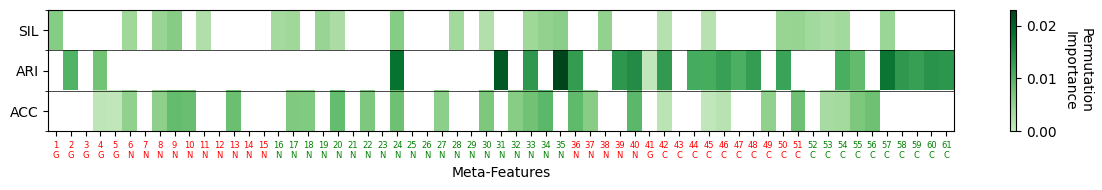

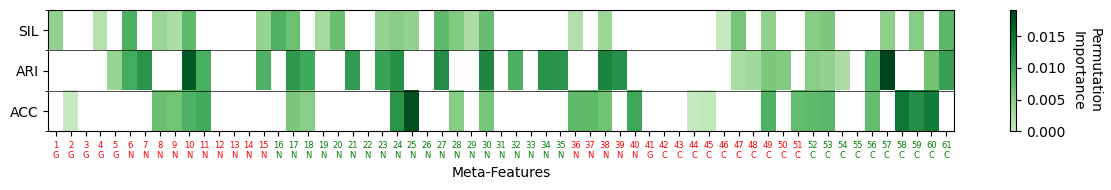

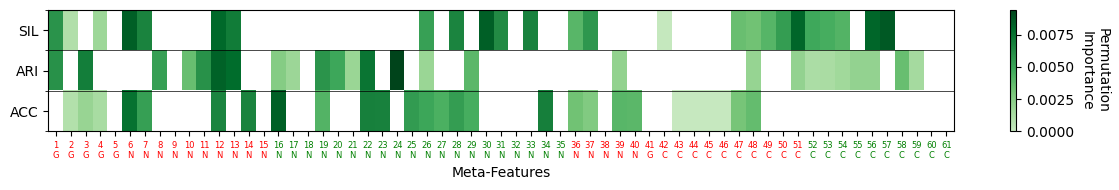

In [22]:
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap = cm.get_cmap('Greens', 256)
newcolors = cmap(np.linspace(0.25, 1, 256))
pink = np.array([1, 1, 1, 1])
newcolors[0] = pink
newcmp = ListedColormap(newcolors)

scorer = make_scorer(lambda yt, yp: np.mean([y[y>-1][np.argmax(yp[i][y>-1])] for i, y in enumerate(yt)]))
for algorithm in ["kprototypes", "fasterpam", "haverage"]:
    y = []
    for eval_metric in ["sil", "ari", "acc"]:
        params = train_res[algorithm][eval_metric]["train_results"]["AMF-FS-KNN"]["params"]
        selected_feats = train_res[algorithm][eval_metric]["train_results"]["AMF-FS-KNN"]["selected_features"]
        X = train_res[algorithm][eval_metric]["X"][:, selected_feats]
        Y = train_res[algorithm][eval_metric]["Y"]
        Yn = train_res[algorithm][eval_metric]["Yn"]
        feature_importance = None
        for train, test in KFold(n_splits=10).split(X):
            knn = KNeighborsRegressor(**params).fit(X[train], Y[train])
            result = permutation_importance(knn, X[test], Yn[test], scoring=scorer, n_repeats=10)
            if feature_importance is None:
                feature_importance = result.importances.mean(axis=1)
            else:
                feature_importance = feature_importance + result.importances.mean(axis=1)
        l = np.zeros(len(selected_feats))
        l[selected_feats] = feature_importance/10
        y.append(l)
    y = np.array(y)

    fig, ax = plt.subplots(figsize=(12, 2))
    im = ax.imshow(y, cmap=newcmp, vmin=0, aspect="auto")
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Permutation\nImportance", rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(mixed_meta_df.shape[1]), labels=[f"{i+1}\n{'N' if f in proposed_attributes_statistics_num else 'C'}" if f in proposed_attributes_statistics else f"{i+1}\n{'G' if f in dataset_statistics else ('N' if f in attributes_statistics_num else 'C')}" for i, f in enumerate(mixed_meta_df.columns)], fontsize=6)
    ax.set_yticks(np.arange(3), labels=[a.upper() for a in ["sil", "ari", "acc"]])
    ax.set_yticks(np.arange(3+1)-.5, minor=True)
    # ax.spines[:].set_visible(False)
    ax.grid(which="minor", axis="y", color="black", linestyle='-', linewidth=0.5)

    # ax.tick_params(axis='x', colors=["green" if f in proposed_attributes_statistics else "red" for f in mixed_meta_df.columns])
    colors = ["green" if f in proposed_attributes_statistics else "red" for f in mixed_meta_df.columns]
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    # for i in range(3):
    #     for j in range(mixed_meta_df.shape[1]):
    #         text = ax.text(j, i, y[i, j],
    #                     ha="center", va="center", color="w")

    ax.set_xlabel("Meta-Features")
    fig.tight_layout()
    # plt.savefig(f"imgs/importance_{eval_metric}.pdf", bbox_inches='tight')
    plt.show()

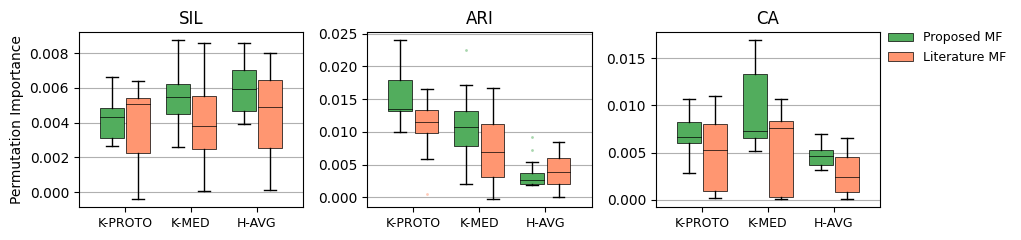

In [27]:
from sklearn.metrics import make_scorer
scorer = make_scorer(lambda yt, yp: np.mean([y[y>-1][np.argmax(yp[i][y>-1])] for i, y in enumerate(yt)]))

def show_feat_imp(train_res, savedir=None):
    labels = ["Proposed MF", "Literature MF"]
    colors = dict(zip(labels, ["#52AD5D", "#FF9671"]))
    fig = plt.figure(figsize=(9, 2.5))
    k = 1
    for j, eval_metric in enumerate(["sil", "ari", "acc"]):
        y = {"Proposed MF": [], "Literature MF": []}
        plt.subplot(1, 3, j+1)
        for algorithm in ["kprototypes", "fasterpam", "haverage"]:
            params = train_res[algorithm][eval_metric]["train_results"]["AMF-FS-KNN"]["params"]
            selected_feats = train_res[algorithm][eval_metric]["train_results"]["AMF-FS-KNN"]["selected_features"]
            selected_feat_names = train_res[algorithm][eval_metric]["selected_features"]
            X = train_res[algorithm][eval_metric]["X"][:, selected_feats]
            Y = train_res[algorithm][eval_metric]["Y"]
            Yn = train_res[algorithm][eval_metric]["Yn"]
            feature_importance = None
            for train, test in KFold(n_splits=10).split(X):
                knn = KNeighborsRegressor(**params).fit(X[train], Y[train])
                result = permutation_importance(knn, X[test], Yn[test], scoring=scorer, n_repeats=10)
                if feature_importance is None:
                    feature_importance = result.importances.mean(axis=1)
                else:
                    feature_importance = feature_importance + result.importances.mean(axis=1)
            feature_importance /= 10
            y["Proposed MF"].append(feature_importance[[f in proposed_attributes_statistics for f in selected_feat_names]])
            y["Literature MF"].append(feature_importance[[f not in proposed_attributes_statistics for f in selected_feat_names]])

        n_bar = len(y)
        w = 0.8/n_bar
        x = np.arange(len(train_res))
        boxes = []
        i = 0
        for label, values in y.items():
            # min_ = min(min_, min(min(val) for val in values))          
            boxprops = dict(linewidth=0.5, facecolor=colors[label], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[label], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.9*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        if j==0: plt.ylabel("Permutation Importance")
        # plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in ["kprototypes", "fasterpam", "haverage"]], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title(eval_metric.upper() if eval_metric != "acc" else "CA")
    plt.figlegend([box["boxes"][0] for box in boxes], labels, fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"feature_importance_top{k}.pdf"), bbox_inches='tight')
    plt.show()

show_feat_imp(train_res) #, savedir="imgs/"

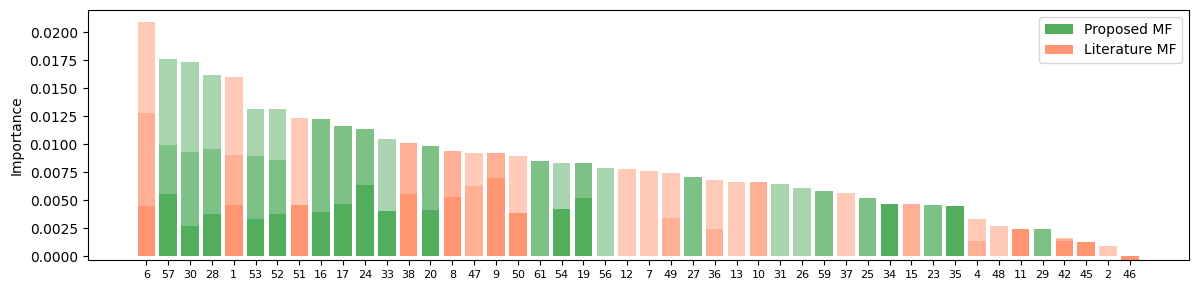

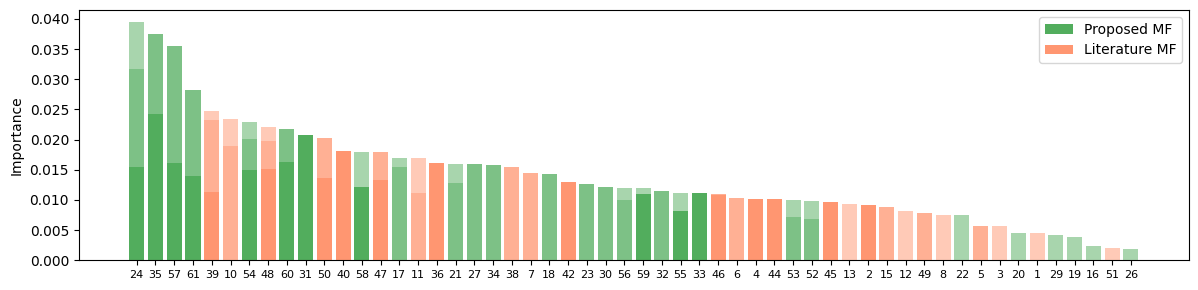

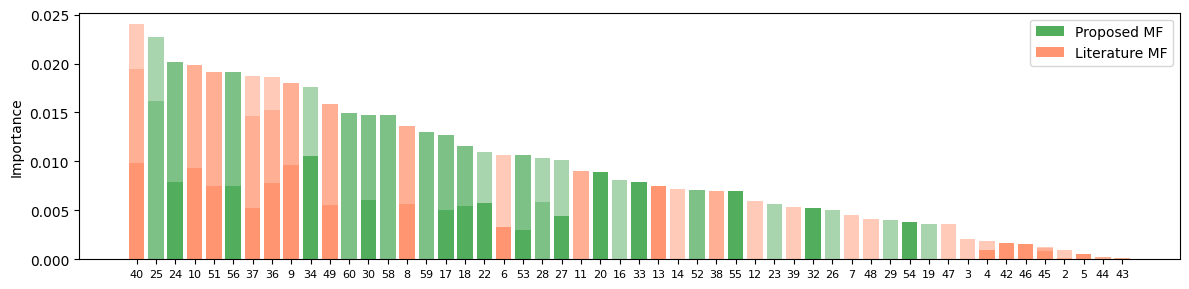

In [17]:
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

scorer = make_scorer(lambda yt, yp: np.mean([y[y>-1][np.argmax(yp[i][y>-1])] for i, y in enumerate(yt)]))
patterns = ["-", "|", "\\"]
for eval_metric in ["sil", "ari", "acc"]:
    y = {}
    for algorithm in ["kprototypes", "fasterpam", "haverage"]:
        params = train_res[algorithm][eval_metric]["train_results"]["AMF-FS-KNN"]["params"]
        selected_feats = train_res[algorithm][eval_metric]["train_results"]["AMF-FS-KNN"]["selected_features"]
        X = train_res[algorithm][eval_metric]["X"][:, selected_feats]
        Y = train_res[algorithm][eval_metric]["Y"]
        Yn = train_res[algorithm][eval_metric]["Yn"]
        feature_importance = None
        for train, test in KFold(n_splits=10).split(X):
            knn = KNeighborsRegressor(**params).fit(X[train], Y[train])
            result = permutation_importance(knn, X[test], Yn[test], scoring=scorer, n_repeats=10)
            if feature_importance is None:
                feature_importance = result.importances.mean(axis=1)
            else:
                feature_importance = feature_importance + result.importances.mean(axis=1)
        y[algorithm] = np.zeros(len(selected_feats))
        y[algorithm][selected_feats] = feature_importance/10
    sum_y = np.array(list(y.values())).sum(axis=0)
    indices = np.array([i for i in np.argsort(-sum_y) if sum_y[i]>0])
    feature_names = [rename(feat) for feat in mixed_meta_df.columns.to_numpy()[indices]]
    plt.figure(figsize=(12, 3))
    bottom = 0
    i = 0
    for algorithm, values in y.items():
        y_ = np.array([v if mixed_meta_df.columns[i] in proposed_attributes_statistics else 0 for i, v in enumerate(values)])
        plt.bar(feature_names, y_[indices], bottom=bottom, label="Proposed MF" if i==0 else "", color="#52AD5D", alpha=1-i*0.25)
        y_ = np.array([v if mixed_meta_df.columns[i] not in proposed_attributes_statistics else 0 for i, v in enumerate(values)])
        plt.bar(feature_names, y_[indices], bottom=bottom, label="Literature MF" if i==0 else "", color="#FF9671", alpha=1-i*0.25)
        bottom += values[indices]
        i += 1
    plt.ylabel("Importance")
    plt.xticks(feature_names, indices+1, fontsize=8)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"imgs/importance_{eval_metric}.pdf")
    plt.show()